In [62]:
from programa_geovars import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df.drop('Unnamed: 0', axis=1, inplace=True)
scaler_lat.fit(train_df.lat.values.reshape(-1, 1))
scaler_lon.fit(train_df.lon.values.reshape(-1, 1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [64]:
zpae = gpd.read_file('./ZPAE/ZPAE/TODAS_ZPAE_ETRS89.shp')

In [17]:
def get_zpae():
    zpae = gpd.read_file('./ZPAE/ZPAE/TODAS_ZPAE_ETRS89.shp')
    mydic = get_lon_lat(zpae, 'zpae')
    mydic['zpae']['ruido'] = zpae.ZonaSupera
    return pd.DataFrame(mydic['zpae'])

In [18]:
zpae = get_zpae()

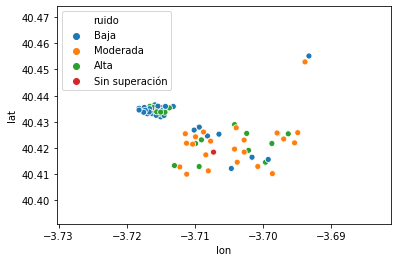

In [20]:
sns.scatterplot(zpae.lon, zpae.lat, hue=zpae.ruido)

In [22]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from functools import lru_cache

In [25]:
train_df.columns

Index(['ID', 'X', 'Y', 'Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3',
       'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8',
       'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2',
       'Q_G_3_0_3', 'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7',
       'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1',
       'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6',
       'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0',
       'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4',
       'Q_NIR_8_0_5', 'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8',
       'Q_NIR_8_0_9', 'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3',
       'GEOM_R4', 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID',
       'CLASE', 'lat', 'lon'],
      dtype='object')

In [27]:
@lru_cache(maxsize=104000)
def distance(p1, p2):
    lon1, lat1 = p1
    lon2, lat2 = p2
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    km = 6367*c
    return km

nbrs = NearestNeighbors(n_neighbors=1, metric=distance)


In [28]:
from scipy.spatial import distance

In [51]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2), np.min(dist_2)

In [52]:
%time
points = [[l for l in train_df[['lon','lat']].iloc[ii]] for ii in range(train_df.shape[0])]
comparing_points = [[l for l in zpae[['lon','lat']].iloc[ii]] for ii in range(zpae.shape[0])]
closest_nodes = [closest_node(point, comparing_points) for point in points]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 31 µs


In [45]:
#plt.hist(closest_nodes)

In [55]:
distances = [t[1] for t in closest_nodes]

In [61]:
np.quantile(distances, 0.5)

0.0016668367489876376

(array([6.2278e+04, 1.5413e+04, 9.6270e+03, 2.5020e+03, 2.2680e+03,
        1.4270e+03, 1.8320e+03, 1.4410e+03, 5.8200e+02, 2.0940e+03,
        1.3800e+03, 1.1790e+03, 1.4800e+02, 7.0000e+00, 1.4000e+01,
        1.1000e+01, 3.3300e+02, 4.4100e+02, 2.5200e+02, 1.0000e+00]),
 array([1.93649261e-11, 2.57460928e-03, 5.14921854e-03, 7.72382780e-03,
        1.02984371e-02, 1.28730463e-02, 1.54476556e-02, 1.80222648e-02,
        2.05968741e-02, 2.31714834e-02, 2.57460926e-02, 2.83207019e-02,
        3.08953111e-02, 3.34699204e-02, 3.60445297e-02, 3.86191389e-02,
        4.11937482e-02, 4.37683574e-02, 4.63429667e-02, 4.89175760e-02,
        5.14921852e-02]),
 <a list of 20 Patch objects>)

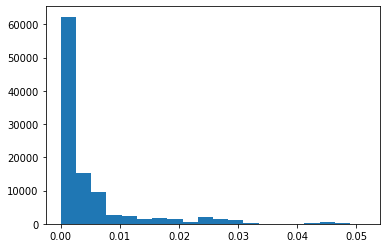

In [60]:
plt.hist(distances, bins=20)

In [50]:
#closest_nodes